## Data preprocessing

In [1]:
import pickle
import numpy as np

In [2]:
with open('train_qa.txt','rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('test_qa.txt','rb') as f:
    test_data = pickle.load(f)

In [4]:
print(type(train_data),type(train_data))

<class 'list'> <class 'list'>


In [5]:
print(len(train_data),len(test_data))

10000 1000


In [6]:
print(
    f"Story    : {' '.join(train_data[0][0])} \n"
    f"Question : {' '.join(train_data[0][1])} \n"
    f"Answer   : {train_data[0][2]} \n"
    )

Story    : Mary moved to the bathroom . Sandra journeyed to the bedroom . 
Question : Is Sandra in the hallway ? 
Answer   : no 



In [7]:
print(
    f"Story    : {' '.join(test_data[0][0])} \n"
    f"Question : {' '.join(test_data[0][1])} \n"
    f"Answer   : {test_data[0][2]} \n"
    )

Story    : Mary got the milk there . John moved to the bedroom . 
Question : Is John in the kitchen ? 
Answer   : no 



In [8]:
all_data = train_data + test_data

In [9]:
len(all_data)

11000

In [10]:
set(train_data[0][0])

{'.',
 'Mary',
 'Sandra',
 'bathroom',
 'bedroom',
 'journeyed',
 'moved',
 'the',
 'to'}

In [11]:
# get all unique words

vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

vocab.add('yes')
vocab.add('no')

In [12]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [13]:
# For keras pad sequences ( add one for place holder later use )
vocab_len = len(vocab) + 1

In [14]:
vocab_len

38

In [15]:
# calculate the longest story
all_story_len = [len(data[0]) for data in all_data]
max_story_len = max(all_story_len)

In [16]:
max_story_len

156

In [17]:
# calculate the longest question
all_question_len = [len(data[1]) for data in all_data]
max_question_len = max(all_question_len)

In [18]:
max_question_len

6

In [19]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [20]:
tokenizer = Tokenizer(filters=[])
#                             |__ disable all filters
tokenizer.fit_on_texts(vocab)

In [21]:
tokenizer.word_index

{'journeyed': 1,
 'bathroom': 2,
 'picked': 3,
 '.': 4,
 'daniel': 5,
 'there': 6,
 'garden': 7,
 'up': 8,
 'in': 9,
 'apple': 10,
 'discarded': 11,
 'office': 12,
 'down': 13,
 'yes': 14,
 'bedroom': 15,
 'travelled': 16,
 'put': 17,
 'milk': 18,
 'no': 19,
 'left': 20,
 'to': 21,
 'john': 22,
 '?': 23,
 'grabbed': 24,
 'dropped': 25,
 'kitchen': 26,
 'the': 27,
 'took': 28,
 'mary': 29,
 'is': 30,
 'sandra': 31,
 'hallway': 32,
 'football': 33,
 'moved': 34,
 'got': 35,
 'back': 36,
 'went': 37}

In [22]:
train_story_text = []
train_question_text = []
train_answers = []

In [23]:
for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [24]:
#train_question_seq = tokenizer.texts_to_sequences(train_question_text)
#train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [25]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_question_len=max_question_len):
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [26]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [27]:
tokenizer.word_index['yes']

14

In [28]:
tokenizer.word_index['no']

19

In [29]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., 497.,   0.,   0.,   0.,   0., 503.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

## Build the model

In [30]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [31]:
# , is for place holder for batch size in tuple (max_story_len, batch_size)
input_sequence = Input((max_story_len, ))
question = Input((max_question_len, ))

## Encoders

### Input Encoder m

In [32]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

### Input Encoder c

In [33]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

### Question Encoder

In [34]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

### Encode the Sequences

In [35]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [36]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [37]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [38]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [39]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [40]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [41]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)  # (samples, vocab_size) yes/no

In [42]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 64)     2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
______________________________________________________________________________________________

## Fit and Train

In [44]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
313/313 [==============================] - 70s 40ms/step - loss: 1.2305 - accuracy: 0.4918 - val_loss: 0.6947 - val_accuracy: 0.4820
Epoch 2/120
313/313 [==============================] - 9s 29ms/step - loss: 0.7071 - accuracy: 0.5089 - val_loss: 0.6977 - val_accuracy: 0.4970
Epoch 3/120
313/313 [==============================] - 9s 30ms/step - loss: 0.6981 - accuracy: 0.4945 - val_loss: 0.6938 - val_accuracy: 0.4970
Epoch 4/120
313/313 [==============================] - 9s 29ms/step - loss: 0.6953 - accuracy: 0.4962 - val_loss: 0.6936 - val_accuracy: 0.5030
Epoch 5/120
313/313 [==============================] - 10s 31ms/step - loss: 0.6945 - accuracy: 0.5047 - val_loss: 0.6953 - val_accuracy: 0.4970
Epoch 6/120
313/313 [==============================] - 10s 33ms/step - loss: 0.6949 - accuracy: 0.5001 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 7/120
313/313 [==============================] - 10s 33ms/step - loss: 0.6943 - accuracy: 0.4975 - val_loss: 0.6934 - val_accur

## Saving the Model

In [45]:
filename = 'chatbot_120_epochs.h5'
model.save(filename)

C:\Users\kavinda\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Plotting Out Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


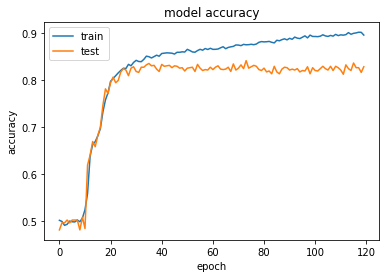

In [46]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Load model

In [ ]:
model.load_weights('chatbot_120_epochs.h5')

In [47]:
pred_results = model.predict(([inputs_test, queries_test]))

In [48]:
pred_results.shape

(1000, 38)

In [49]:
pred_results[0]

array([4.6051233e-17, 4.8714817e-17, 4.4434941e-17, 4.8211229e-17,
       5.0069444e-17, 4.5813990e-17, 4.7968346e-17, 5.4326030e-17,
       5.0289957e-17, 5.0689413e-17, 4.7875116e-17, 4.6526580e-17,
       5.4984231e-17, 4.1470726e-17, 1.5170582e-06, 4.8340878e-17,
       5.0349849e-17, 5.0634915e-17, 4.7130362e-17, 9.9999845e-01,
       4.7105200e-17, 4.8250970e-17, 4.7526112e-17, 4.8753112e-17,
       4.9987001e-17, 4.8849545e-17, 4.5437352e-17, 4.7101246e-17,
       4.6696208e-17, 4.8228154e-17, 4.5857702e-17, 5.9484345e-17,
       4.9312372e-17, 4.8453127e-17, 5.7932428e-17, 4.3352820e-17,
       5.7647825e-17, 4.6280881e-17], dtype=float32)

In [57]:
tokenizer.word_index['yes']

14

In [58]:
tokenizer.word_index['no']

19

In [55]:
pred_results[0][14] # yes or no

1.5170582e-06

In [51]:
pred_results[0][19] # yes or no

0.99999845

In [52]:
val_max = np.argmax(pred_results[0])

In [53]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [54]:
k

'no'

In [59]:
pred_results[0][val_max]

0.99999845

## My story

In [60]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [61]:
my_question = "Is the football in the garden ?"
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [62]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [63]:
mydata

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [64]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [67]:
pred_results = model.predict(([ my_story, my_ques]))

In [68]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.99617434
